# 目的
- 基礎的な集計をする

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt

import ChocoUtils as util

from datetime import datetime as dt

# データの取得

# 基礎集計

In [2]:
def output_hist(data, plt_file, min_range=27.0, max_range=31.0, step=0.1, spec=28.0):
    b = np.arange(min_range, max_range, step)
    ret = plt.hist(data['net_weight'], 
                   bins=b, color="#0000FF", alpha=0.5, edgecolor="#0000FF", 
                   label='measure', normed=True)
    plt.vlines(x=spec, ymin=0, ymax=ret[0].max(), 
               colors='#FF0000', linewidths=2, label='spec')
    # 最尤推定パラメータの分布
    x = np.linspace(min_range, max_range, 300)
    y = stats.norm.pdf(x, loc=data['net_weight'].mean(), scale=data['net_weight'].std())
    plt.plot(x, y, lw=3, color='#0000FF', label='MLE')
    plt.legend()
    plt.xlabel('net weight [g]')
    plt.ylabel('frequency')
    #plt.savefig(plt_file)
    print('save_figure : {}'.format(plt_file))

In [3]:
def main():
    db_file = '../../data/choco-ball.db'
    table_name = 'measurement'
    filter_str = 'taste=0'
    # 計測データ取得
    m_data = util.get_data(db_file=db_file, table_name=table_name, filter_str=filter_str)
    # ファイル名のラベルのために日付を取得
    t_str = util.get_date_str()
    # データ集計
    output_hist(data=m_data, plt_file='fig/base_hist_{}.png'.format(t_str), min_range=27,max_range=31, spec=28)
    # 表示用
    print('| 計測データ数 | {} |'.format(m_data.shape[0]))
    print('| 銀のエンゼル出現数 | {} |'.format((m_data['angel']==1).sum()))
    print('| 金のエンゼル出現数 | {} |'.format((m_data['angel']==2).sum()))
    print('| 正味重量 | %2.3f | %2.3f | %2.3f | %2.3f |' % (
        (m_data['net_weight']).min(), (m_data['net_weight']).median(), 
        (m_data['net_weight']).max(), (m_data['net_weight']).mean()))
    print('| 個数 | %2.3f | %2.3f | %2.3f | %2.3f |' % (
        (m_data['ball_number']).min(), (m_data['ball_number']).median(), 
        (m_data['ball_number']).max(), (m_data['ball_number']).mean()))
    return m_data

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste=0;
Shape of MeasurementData(record_num, n_columns) : (309, 14)
save_figure : fig/base_hist_2018-12-24.png
| 計測データ数 | 309 |
| 銀のエンゼル出現数 | 10 |
| 金のエンゼル出現数 | 1 |
| 正味重量 | 28.750 | 29.389 | 32.232 | 29.495 |
| 個数 | 14.000 | 17.000 | 20.000 | 16.573 |


/Users/tok41/workspace/choco-ball-statistics/env_choco/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


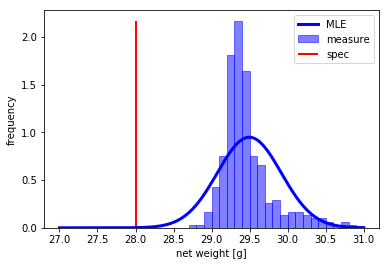

In [4]:
data = main()